# SpaceX Falcon 9 first stage Landing Prediction

In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import sqlalchemy

pd.options.display.max_rows = 999
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

## Part 1 - Collecting data via SpaceX API

### Making some functions for extracting data from JSON

In [3]:
# Takes the dataset and uses the rocket column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

In [4]:
# Takes the dataset and uses the launchpad column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
        response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
        Longitude.append(response['longitude'])
        Latitude.append(response['latitude'])
        LaunchSite.append(response['name'])

In [5]:
# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

In [6]:
# Takes the dataset and uses the cores column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

In [7]:
spacex_url = "https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
#print(response.content)
response.status_code

200

In [8]:
launch_data_df = pd.json_normalize(response.json())
launch_data_df.head(2)

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,capsules,payloads,launchpad,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,auto_update,tbd,launch_library_id,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,https://images2.imgbox.com/40/e3/GypSkayF_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]","Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",True,False,None,5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN


In [9]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = launch_data_df[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].apply(len)==1]
data = data[data['payloads'].apply(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [10]:
data.head(1)


,rocket,payloads,launchpad,cores,flight_number,date_utc,date
0,5e9d0d95eda69955f709d1eb,5eb0e4b5b6c3bb0006eeb1e1,5e9e4502f5090995de566f86,"{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}",1,2006-03-24T22:30:00.000Z,2006-03-24


*   From the <code>rocket</code> we would like to learn the booster name

*   From the <code>payload</code> we would like to learn the mass of the payload and the orbit that it is going to

*   From the <code>launchpad</code> we would like to know the name of the launch site being used, the longitude, and the latitude.

*   From <code>cores</code> we would like to learn the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

The data from these requests will be stored in lists and will be used to create a new dataframe.

In [11]:
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

### Applying functions for data extraction

In [12]:
getBoosterVersion(data)
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

### Constructing dictionary for the new DF

In [13]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [14]:
launch_data = pd.DataFrame(launch_dict)
# getting rid of all flights except Falcon 9
launch_data = launch_data[launch_data.BoosterVersion != 'Falcon 1'] 
launch_data.loc[:,'FlightNumber'] = list(range(1, launch_data.shape[0]+1))
data_falcon9 = launch_data

### See how many missing values we have in dataset

In [15]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

#### Let's replace missing values with mean. And we will leave "LandingPad" as NaN, because NaN in this case represents the absence of landing pads at that particular launch. 

In [16]:
mean_value = data_falcon9.PayloadMass.mean()

data_falcon9.PayloadMass = data_falcon9.PayloadMass.replace(to_replace=np.nan, value = mean_value)
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


### Chack for missing values again.

In [17]:
data_falcon9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

## Part 2 - Web scraping Falcon 9 and Falcon Heavy Launches Records from Wikipedia

### Now we have to extract Falcon 9 launch records from wikipedia and convert it to DataFrame 

In [18]:
df_list = pd.read_html('List of Falcon 9 and Falcon Heavy launches - Wikipedia.html')

In [19]:
launches_df = pd.concat(df_list[2:11])

In [20]:
df0 = pd.DataFrame()

for x in range(launches_df.shape[0]):
    if not launches_df['Boosterlanding'].iloc[x] == launches_df['Customer'].iloc[x] :
        df0 = df0.append(launches_df.iloc[x], ignore_index=True)

In [21]:
d ={
    'Flight number': df0['Flight No.'],
    'Launch site': df0['Launch site'],
    'Payload mass': df0['Payload mass'],
    'Orbit': df0['Orbit'],
    'Customer': df0['Customer'],
    'Launch outcome': df0['Launchoutcome'],
    'Version Booster': np.nan,
    'Booster landing': df0['Boosterlanding'],
    'Date': df0['Date andtime (UTC)'],
    'Time': df0['Date andtime (UTC)']
}
df1 = pd.DataFrame(data=d)

In [22]:
df1.head(2)

,Flight number,Launch site,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1.0,"CCAFS,SLC-40",NaN,LEO,SpaceX,Success,NaN,Failure[9][10](parachute),"4 June 2010,18:45","4 June 2010,18:45"
1,2.0,"CCAFS,SLC-40",NaN,LEO (ISS),NASA (COTS) NRO,Success[9],NaN,Failure[9][14](parachute),"8 December 2010,15:43[13]","8 December 2010,15:43[13]"


## Part 3 - EDA (Explotratory data analysis)

#### *We well work with API version of the data as it is cleaner

#### Calculate percentage of missing values in each attribute

In [23]:
data_falcon9.isnull().sum()/data_falcon9.count()*100

FlightNumber       0.000
Date               0.000
BoosterVersion     0.000
PayloadMass        0.000
Orbit              0.000
LaunchSite         0.000
Outcome            0.000
Flights            0.000
GridFins           0.000
Reused             0.000
Legs               0.000
LandingPad        40.625
Block              0.000
ReusedCount        0.000
Serial             0.000
Longitude          0.000
Latitude           0.000
dtype: float64

#### Take a look on categorical and numerical columns

In [24]:
data_falcon9.dtypes

FlightNumber        int64
Date               object
BoosterVersion     object
PayloadMass       float64
Orbit              object
LaunchSite         object
Outcome            object
Flights             int64
GridFins             bool
Reused               bool
Legs                 bool
LandingPad         object
Block             float64
ReusedCount         int64
Serial             object
Longitude         float64
Latitude          float64
dtype: object

#### Number of launches per site

In [25]:
data_falcon9.LaunchSite.value_counts()

CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: LaunchSite, dtype: int64

#### Number of launches per orbit

In [26]:
data_falcon9.Orbit.value_counts()

GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: Orbit, dtype: int64

#### Number of ocurances per outcome

In [27]:
data_falcon9.Outcome.value_counts()

True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: Outcome, dtype: int64

In [28]:
landing_outcomes = data_falcon9.Outcome.value_counts()

#### Getting list of unsuccessfull launches

In [29]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)
    
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

#### Creating labels for the new column and attaching it

In [30]:
landing_class = []
for x in data_falcon9.Outcome:
    if x in bad_outcomes:
        landing_class.append(0)
    else:
        landing_class.append(1)

In [31]:
data_falcon9['Class']=landing_class
data_falcon9[['Class']].value_counts()

Class
1        60
0        30
dtype: int64

In [32]:
data_falcon9.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


#### Success rate

In [33]:
print(round(data_falcon9["Class"].mean()*100,2), '%')

66.67 %


## Part 4. EDA with SQL

#### Loading csv data into Pandas DF and then into SQLite database

In [34]:
data_for_sql = pd.read_csv('Spacex.csv')

In [35]:
data_for_sql = data_for_sql.astype({'Date':'datetime64',
                                   'Time (UTC)':'datetime64'})

In [36]:
data_for_sql.head(1)

,Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing _Outcome
0,2010-04-06,2021-09-17 18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)


In [37]:
data_for_sql.dtypes

Date                 datetime64[ns]
Time (UTC)           datetime64[ns]
Booster_Version              object
Launch_Site                  object
Payload                      object
PAYLOAD_MASS__KG_             int64
Orbit                        object
Customer                     object
Mission_Outcome              object
Landing _Outcome             object
dtype: object

In [38]:
engine = sqlalchemy.create_engine('sqlite:///spacex.db', echo = True)

In [39]:
data_for_sql.to_sql('spacex', con=engine, if_exists='replace')

2021-09-17 16:41:36,429 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("spacex")
2021-09-17 16:41:36,430 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-09-17 16:41:36,432 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("spacex")
2021-09-17 16:41:36,432 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-09-17 16:41:36,434 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2021-09-17 16:41:36,434 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-09-17 16:41:36,435 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("spacex")
2021-09-17 16:41:36,436 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-09-17 16:41:36,438 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2021-09-17 16:41:36,439 INFO sqlalchemy.engine.Engine [raw sql] ('spacex',)
2021-09-17 16:41:36,440 INFO sqlalchemy.engine.Engine PRAGMA main.foreign_key_list("spacex")
202

#### Now we make running queries from Jupyter possible with magic ipython-sql. And connect to our database.

In [40]:
%load_ext sql

In [41]:
%sql sqlite:///spacex.db

#### Check and reformat dates and times

In [42]:
%%sql
PRAGMA table_info(spacex);

 * sqlite:///spacex.db
Done.


cid,name,type,notnull,dflt_value,pk
0,index,BIGINT,0,None,0
1,Date,DATETIME,0,None,0
2,Time (UTC),DATETIME,0,None,0
3,Booster_Version,TEXT,0,None,0
4,Launch_Site,TEXT,0,None,0
5,Payload,TEXT,0,None,0
6,PAYLOAD_MASS__KG_,BIGINT,0,None,0
7,Orbit,TEXT,0,None,0
8,Customer,TEXT,0,None,0
9,Mission_Outcome,TEXT,0,None,0


#### Checking date and time functions for future queries

In [43]:
%%sql
select date(Date), time("Time (UTC)")
from spacex
limit 2;

 * sqlite:///spacex.db
Done.


date(Date),"time(""Time (UTC)"")"
2010-04-06,18:45:00
2010-08-12,15:43:00


#### 4.1 - Names of the Unique lauch sites.

In [44]:
%%sql
select distinct launch_site from spacex;

 * sqlite:///spacex.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


#### 4.2 - 5 records where launch sites begin with the string 'CCA'

In [45]:
%%sql
select * from spacex
where launch_site like 'CCA%'
limit 5;

 * sqlite:///spacex.db
Done.


index,Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing _Outcome
0,2010-04-06 00:00:00.000000,2021-09-17 18:45:00.000000,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
1,2010-08-12 00:00:00.000000,2021-09-17 15:43:00.000000,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2,2012-05-22 00:00:00.000000,2021-09-17 07:44:00.000000,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
3,2012-08-10 00:00:00.000000,2021-09-17 00:35:00.000000,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
4,2013-01-03 00:00:00.000000,2021-09-17 15:10:00.000000,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


#### 4.3 - Total payload mass carried by boosters launched by NASA (CRS)

In [46]:
%%sql
select sum(payload_mass__kg_) total_mass_by_nasacrs
from spacex
where customer = 'NASA (CRS)';

 * sqlite:///spacex.db
Done.


total_mass_by_nasacrs
45596


#### 4.4 - Average payload mass carried by booster version F9 v1.1

In [47]:
%%sql
select avg(payload_mass__kg_) avg_mass
from spacex
where booster_version like 'F9 v1.0%';

 * sqlite:///spacex.db
Done.


avg_mass
340.4


#### 4.5 - The date when the first successful landing outcome in ground pad was acheived.

In [48]:
%%sql
select min(date(Date)) Date
from spacex
where "Landing _Outcome" = 'Success (ground pad)';

 * sqlite:///spacex.db
Done.


Date
2015-12-22


#### 4.6 - The names of the boosters which have success in drone ship and have payload mass greater than 4000 but less than 6000

In [49]:
%%sql
select Booster_Version booster_name, PAYLOAD_MASS__KG_, "Landing _Outcome"
from spacex
where ("Landing _Outcome" = 'Success (drone ship)') and (PAYLOAD_MASS__KG_ between 4000 and 6000);

 * sqlite:///spacex.db
Done.


booster_name,PAYLOAD_MASS__KG_,Landing _Outcome
F9 FT B1022,4696,Success (drone ship)
F9 FT B1026,4600,Success (drone ship)
F9 FT B1021.2,5300,Success (drone ship)
F9 FT B1031.2,5200,Success (drone ship)


#### 4.7 - Total number of successful and failure mission outcomes

In [50]:
%%sql
select Mission_Outcome, count(*) count_outcomes
from spacex
group by Mission_Outcome;

 * sqlite:///spacex.db
Done.


Mission_Outcome,count_outcomes
Failure (in flight),1
Success,98
Success,1
Success (payload status unclear),1


In [51]:
%%sql 
select count(*) total_outcomes
from spacex;

 * sqlite:///spacex.db
Done.


total_outcomes
101


#### 4.8 - Names of the booster_versions which have carried the maximum payload mass. Use a subquery

In [52]:
%%sql
select Booster_Version, PAYLOAD_MASS__KG_
from spacex
where PAYLOAD_MASS__KG_ = (select max(PAYLOAD_MASS__KG_)
                           from spacex
                          ); 

 * sqlite:///spacex.db
Done.


Booster_Version,PAYLOAD_MASS__KG_
F9 B5 B1048.4,15600
F9 B5 B1049.4,15600
F9 B5 B1051.3,15600
F9 B5 B1056.4,15600
F9 B5 B1048.5,15600
F9 B5 B1051.4,15600
F9 B5 B1049.5,15600
F9 B5 B1060.2,15600
F9 B5 B1058.3,15600
F9 B5 B1051.6,15600


#### 4.9 - failed landing_outcomes in drone ship, their booster versions, and launch site names for in year 2015

In [53]:
%%sql
select "Landing _Outcome", Booster_Version, Launch_Site, date(Date)
from spacex
where "Landing _Outcome" like 'Failure (drone ship)' and Date like '2015%' ;

 * sqlite:///spacex.db
Done.


Landing _Outcome,Booster_Version,Launch_Site,date(Date)
Failure (drone ship),F9 v1.1 B1012,CCAFS LC-40,2015-10-01
Failure (drone ship),F9 v1.1 B1015,CCAFS LC-40,2015-04-14


#### 4.10 - Rank the count of landing outcomes (such as Failure (drone ship) or Success (ground pad)) between the date 2010-06-04 and 2017-03-20, in descending order

In [54]:
%%sql
with t2 as (
            with t as (select *
                      from spacex
                      where Date >= date('2010-06-04 00:00:00') and Date < date('2017-03-20 00:00:00')
                      )
            select "Landing _Outcome", count("Landing _Outcome") count_outcomes
            from t
            group by "Landing _Outcome"
            )
select "Landing _Outcome", count_outcomes,
RANK() OVER(ORDER BY count_outcomes DESC) AS Rank_No
from t2;

 * sqlite:///spacex.db
Done.


Landing _Outcome,count_outcomes,Rank_No
No attempt,10,1
Failure (drone ship),5,2
Success (drone ship),5,2
Success (ground pad),5,2
Controlled (ocean),3,5
Uncontrolled (ocean),2,6
Failure (parachute),1,7
Precluded (drone ship),1,7


## Part 5. EDA with Visualization. Matplotlib. Future engineering.

### Success or failure of Flight number to Payload mass.

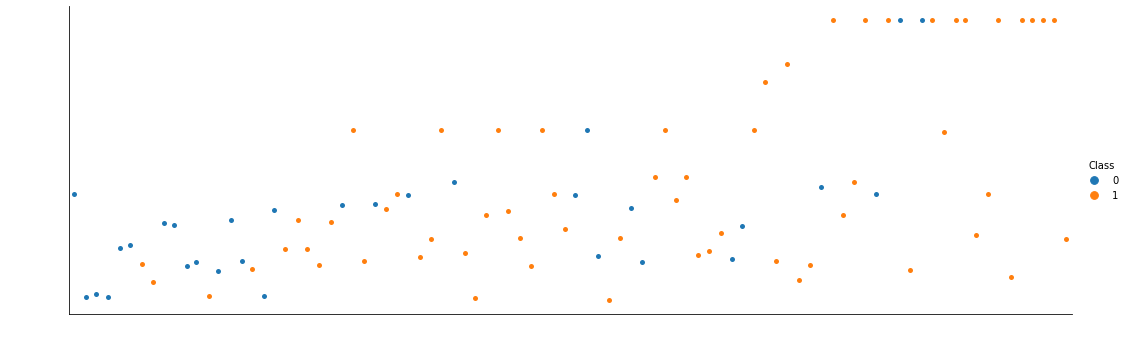

In [128]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 3)
plt.xlabel("Flight Number",fontsize=20, color='white')
plt.ylabel("Payload Mass (kg)",fontsize=20, color='white')
plt.tick_params(axis='x', colors='white')    
plt.tick_params(axis='y', colors='white')
plt.show()

### Success or failure of Flight number to Launch Site.

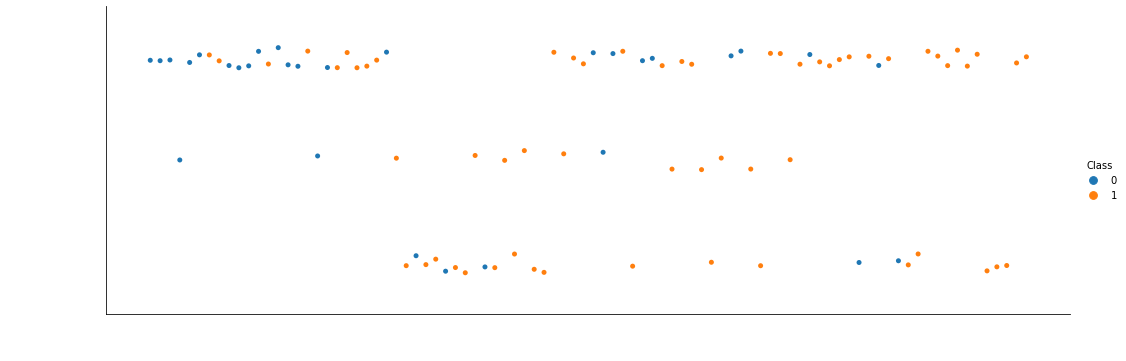

In [127]:
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 3)
plt.xlabel("Flight Number",fontsize=20, color='white')
plt.ylabel("Launch Site",fontsize=20, color='white')
plt.tick_params(axis='x', colors='white')    
plt.tick_params(axis='y', colors='white')
plt.show()

### Success or failure of Payload mass to Launch Site.

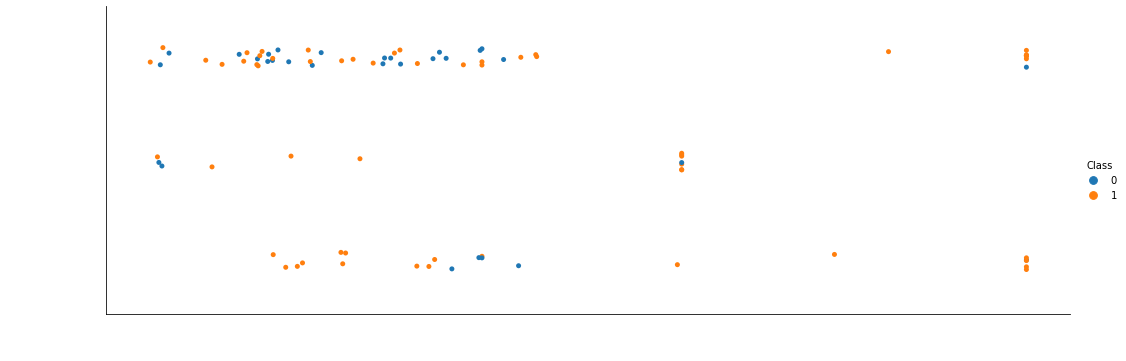

In [129]:
sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=data_falcon9, aspect = 3)
plt.xlabel("Payload Mass (kg)",fontsize=20, color='white')
plt.ylabel("Launch Site",fontsize=20, color='white')
plt.tick_params(axis='x', colors='white')    
plt.tick_params(axis='y', colors='white')
plt.show()

### Success Rate per orbit

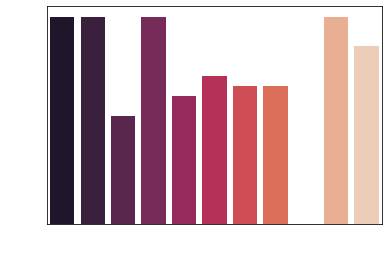

In [137]:
x = data_falcon9.groupby(by='Orbit').mean().index
y = data_falcon9.groupby(by='Orbit').mean().Class
sns.barplot(x=x, y=y, palette="rocket")
plt.xlabel('Orbit', fontsize=13, color='white')
plt.ylabel('Success Rate', fontsize=13, color='white')
plt.tick_params(axis='x', colors='white')    
plt.tick_params(axis='y', colors='white')

### Success of Flight Number vs Orbit type

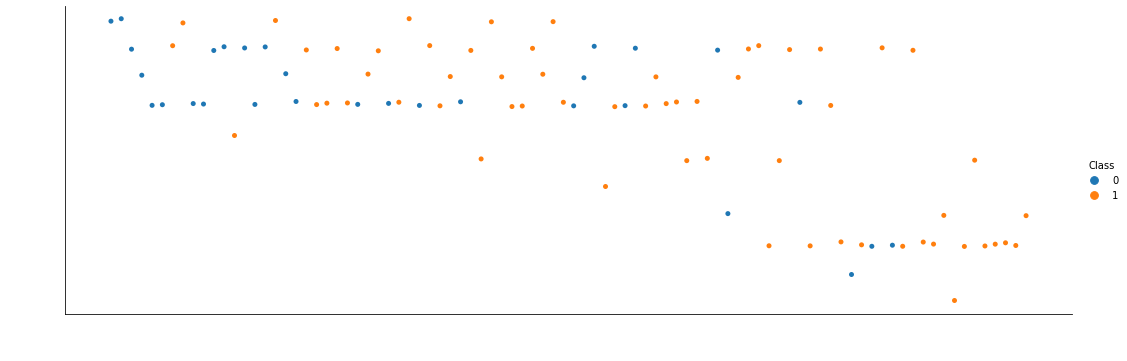

In [130]:
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 3)
plt.xlabel("Flight Number",fontsize=20, color='white')
plt.ylabel("Orbit Type",fontsize=20, color='white')
plt.tick_params(axis='x', colors='white')    
plt.tick_params(axis='y', colors='white')
plt.show()

### Payload vs Orbit Type

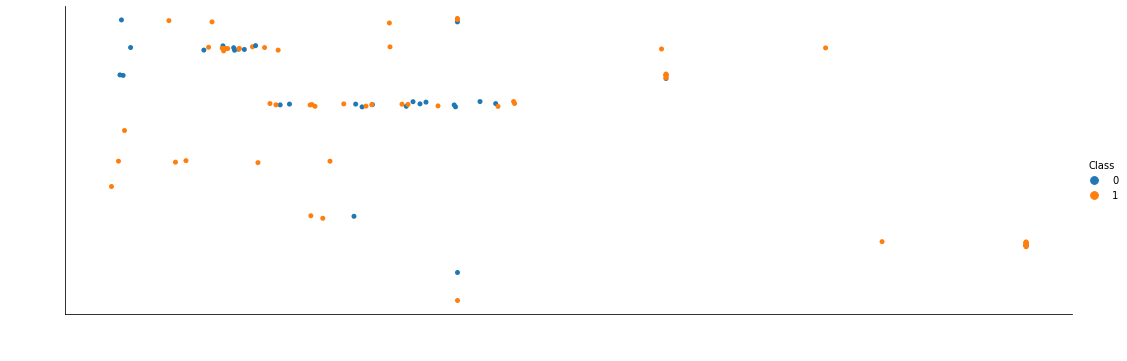

In [131]:
sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=data_falcon9, aspect = 3)
plt.xlabel("Payload Mass (kg)",fontsize=20, color='white')
plt.ylabel("Orbit Type",fontsize=20, color='white')
plt.tick_params(axis='x', colors='white')    
plt.tick_params(axis='y', colors='white')
plt.show()

### Success rate over years

In [58]:
year=[]
for i in data_falcon9["Date"]:
    year.append(i.year)

In [59]:
data_falcon9['Year'] = year

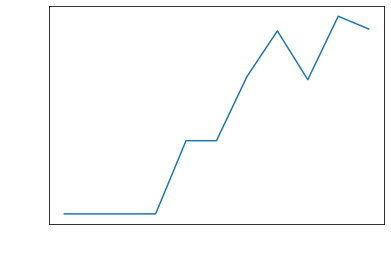

In [139]:
x = data_falcon9.groupby(by='Year').mean().index
y = data_falcon9.groupby(by='Year').mean().Class
sns.lineplot(x=x, y=y)
plt.xlabel("Year",fontsize=15, color ='white')
plt.ylabel("Success Rate",fontsize=15, color='white')
plt.tick_params(axis='x', colors='white')    
plt.tick_params(axis='y', colors='white')
plt.show()

### Features Engieering

In [61]:
features = data_falcon9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


#### Create dummy variables to categorical columns

In [62]:
orbits = pd.get_dummies(features.Orbit)
launchsite = pd.get_dummies(features.LaunchSite)
landingpad = pd.get_dummies(features.LandingPad)
serial = pd.get_dummies(features.Serial)

features_new = features.drop(columns=['Orbit', 'LaunchSite', 'LandingPad', 'Serial'])
features_one_hot = pd.concat([features_new,orbits,launchsite,landingpad,serial], axis=1)
features_one_hot.head(3)

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,ES-L1,GEO,GTO,HEO,ISS,LEO,MEO,PO,SO,SSO,VLEO,CCSFS SLC 40,KSC LC 39A,VAFB SLC 4E,5e9e3032383ecb267a34e7c7,5e9e3032383ecb554034e7c9,5e9e3032383ecb6bb234e7ca,5e9e3032383ecb761634e7cb,5e9e3033383ecbb9e534e7cc,B0003,B0005,B0007,B1003,B1004,B1005,B1006,B1007,B1008,B1010,B1011,B1012,B1013,B1015,B1016,B1017,B1018,B1019,B1020,B1021,B1022,B1023,B1025,B1026,B1028,B1029,B1030,B1031,B1032,B1034,B1035,B1036,B1037,B1038,B1039,B1040,B1041,B1042,B1043,B1044,B1045,B1046,B1047,B1048,B1049,B1050,B1051,B1054,B1056,B1058,B1059,B1060,B1062
4,1,6123.547647,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,525.000000,1,False,False,False,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,3,677.000000,1,False,False,False,1.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Casting all DF to float for modeling

In [63]:
features_one_hot = features_one_hot.astype('float64')
features_one_hot.dtypes.head(7)

FlightNumber    float64
PayloadMass     float64
Flights         float64
GridFins        float64
Reused          float64
Legs            float64
Block           float64
dtype: object

## Part 6 - Launch sites location analysis

#### We will visualize Launch sites and successfull / unssuccesfull tries on a map utilizing Folium library

In [64]:
import folium
import wget

In [65]:
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon

In [66]:
spacex_df = data_falcon9[['LaunchSite', 'Latitude', 'Longitude', 'Class']]
launch_sites_df = spacex_df.groupby(['LaunchSite'], as_index=False).nth(1) 
launch_sites_df = launch_sites_df[['LaunchSite', 'Latitude', 'Longitude']]
launch_sites_df = launch_sites_df.rename(columns={'LaunchSite':'Launch Site',
                               'Latitude':'Lat',
                               'Longitude':'Long'})

In [67]:
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

In [68]:
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)

# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
for row in launch_sites_df.iterrows():
    circle = folium.Circle([row[1].loc['Lat'], row[1].loc['Long']],
                           radius=1000, color='#a1caf1', fill=True).add_child(folium.Popup(row[1].loc['Launch Site']))
    marker = folium.map.Marker(
        [row[1].loc['Lat'], row[1].loc['Long']],
        # Create an icon as a text label
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0),
            html='<div style="font-size: 12; color:#007fff;"><b>%s</b></div>' % row[1].loc['Launch Site'],
            )
        )
    site_map.add_child(circle)
    site_map.add_child(marker)
    
site_map

In [69]:
spacex_df = spacex_df.rename(columns={'LaunchSite':'Launch Site',
                                   'Latitude':'Lat',
                                   'Longitude':'Long'})
spacex_df.head(2)

,Launch Site,Lat,Long,Class
4,CCSFS SLC 40,28.561857,-80.577366,0
5,CCSFS SLC 40,28.561857,-80.577366,0


#### Creating new columns to indicate failure or success using colors. Red - failure. Green - success.

In [70]:
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['Class'].apply(assign_marker_color)
spacex_df.head(7)

,Launch Site,Lat,Long,Class,marker_color
4,CCSFS SLC 40,28.561857,-80.577366,0,red
5,CCSFS SLC 40,28.561857,-80.577366,0,red
6,CCSFS SLC 40,28.561857,-80.577366,0,red
7,VAFB SLC 4E,34.632093,-120.610829,0,red
8,CCSFS SLC 40,28.561857,-80.577366,0,red
9,CCSFS SLC 40,28.561857,-80.577366,0,red
10,CCSFS SLC 40,28.561857,-80.577366,1,green


In [71]:
spacex_df['Launch Site'].unique()

array(['CCSFS SLC 40', 'VAFB SLC 4E', 'KSC LC 39A'], dtype=object)

#### Now let's add all launches on a map utilizing class MarkerCluster() from folium plugins.

In [72]:
coordinates = list(zip(spacex_df['Lat'], spacex_df['Long']))

icons = []
for x in spacex_df['marker_color']:
    icon = folium.Icon(color='white', icon_color=x)
    icons.append(icon)

marker_cluster = MarkerCluster(coordinates,
                               icons = icons)
site_map.add_child(marker_cluster)

### Calculate the distances between a launch site to its proximities. 
*This part doesn't have anything to do with the actual analysis. I am just exploring the capabilities of Folium to measure distances. Here I will pick few locaions (Lat,Long) and measure the distance to one of the launch sites, visualizing it with red lines to distance.

In [73]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

In [74]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

#### Getting the distance for one location and geting the (Lat,Long) for one of the Launch Sites

In [75]:
lat1 = spacex_df[spacex_df['Launch Site'] == 'KSC LC 39A'].iloc[0].loc['Lat']
lon1 = spacex_df[spacex_df['Launch Site'] == 'KSC LC 39A'].iloc[0].loc['Long']

distance_railway = calculate_distance(lat1, lon1, 28.31889, -80.60974)
distance_railway = round(distance_railway,2)
print(distance_railway, 'Kilometers')

32.17 Kilometers


#### Getting the distance and plotting the distance red lines for several locations

In [76]:
points = [(lat1, lon1),(28.31889, -80.60974)]
points.extend([(27.28515,-80.35377),
             (25.78011,-80.21352),
             (28.5411,-81.38378),
             (42.01308,-87.69817)])


for i,x in enumerate(points):
    try:
        folium.PolyLine(locations=[points[1],points[i+1]], color='red').add_to(site_map)
    except IndexError:
        pass
    distance = calculate_distance(lat1, lon1, *x)
    folium.Marker(x, popup = f'Distance {distance} KM.',
                      icon=folium.Icon(color='purple',prefix='fa',icon='anchor'),
                      tooltip=f'Distance {distance} KM.').add_to(site_map)
site_map

## Part 7 - Predicting the ouctomes of possible Launches

In [77]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])

In [78]:
features_one_hot.tail()

,FlightNumber,PayloadMass,Flights,GridFins,Reused,Legs,Block,ReusedCount,ES-L1,GEO,GTO,HEO,ISS,LEO,MEO,PO,SO,SSO,VLEO,CCSFS SLC 40,KSC LC 39A,VAFB SLC 4E,5e9e3032383ecb267a34e7c7,5e9e3032383ecb554034e7c9,5e9e3032383ecb6bb234e7ca,5e9e3032383ecb761634e7cb,5e9e3033383ecbb9e534e7cc,B0003,B0005,B0007,B1003,B1004,B1005,B1006,B1007,B1008,B1010,B1011,B1012,B1013,B1015,B1016,B1017,B1018,B1019,B1020,B1021,B1022,B1023,B1025,B1026,B1028,B1029,B1030,B1031,B1032,B1034,B1035,B1036,B1037,B1038,B1039,B1040,B1041,B1042,B1043,B1044,B1045,B1046,B1047,B1048,B1049,B1050,B1051,B1054,B1056,B1058,B1059,B1060,B1062
89,86.0,15600.0,2.0,1.0,1.0,1.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
90,87.0,15600.0,3.0,1.0,1.0,1.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
91,88.0,15600.0,6.0,1.0,1.0,1.0,5.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
92,89.0,15600.0,3.0,1.0,1.0,1.0,5.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
93,90.0,3681.0,1.0,1.0,0.0,1.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [79]:
features_one_hot.shape

(90, 80)

#### Now, we have to add out Labels from data_falcon9

In [80]:
features_one_hot['Class'] = data_falcon9.Class

In [81]:
data = features_one_hot

#### Separating Y and X and Scaling X

In [82]:
Y = data['Class'].to_numpy()

In [83]:
scaler = preprocessing.StandardScaler()
X = data.drop(columns='Class')
X = scaler.fit_transform(X)

#### Spliting data for testing and training

In [84]:
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size=0.2, random_state=2)

### Hyper-parameter optimization for 4 different models using GridSearchCV from sklearn

#### 1. Logistic regression

In [85]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs','liblinear']}
lr=LogisticRegression()
logreg_cv = GridSearchCV(estimator=lr, param_grid=parameters, cv=10, scoring='precision')
logreg_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='precision')

In [86]:
print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :", logreg_cv.best_score_)

tuned hyperparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.8949999999999999


In [87]:
logreg_cv_score = logreg_cv.score(X_test, Y_test)
logreg_cv_score

0.9

#### LogReg Confusion matrix

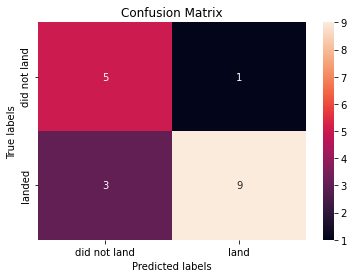

In [88]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### 2. Support Vector Machine

In [89]:
parameters_svm = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [90]:
svm_cv = GridSearchCV(estimator=svm, param_grid=parameters_svm, cv=10, scoring='precision')
svm_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')},
             scoring='precision')

In [91]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1000.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.865


In [92]:
svm_cv_score = svm_cv.score(X_test, Y_test)
svm_cv_score

1.0

#### SVM Confusion Matrix

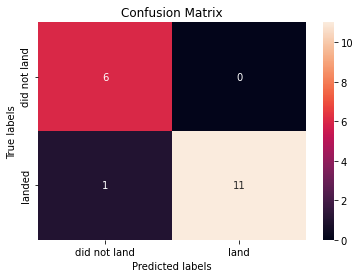

In [93]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### 3. Decision Tree Classifier 

In [94]:
parameters_tree = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [95]:
tree_cv = GridSearchCV(estimator=tree, param_grid=parameters_tree, cv=10, scoring='precision')
tree_cv.fit(X_train, Y_train)

D:\Study 2018 and later\Python codes 3 2020 Work Folder\space-launch-prediction\env_space_launch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Study 2018 and later\Python codes 3 2020 Work Folder\space-launch-prediction\env_space_launch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Study 2018 and later\Python codes 3 2020 Work Folder\space-launch-prediction\env_space_launch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_div

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='precision')

In [96]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 18, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.9233333333333335


In [97]:
tree_cv_score = tree_cv.score(X_test, Y_test)
tree_cv_score

0.9230769230769231

#### Decission tree confusion matrix

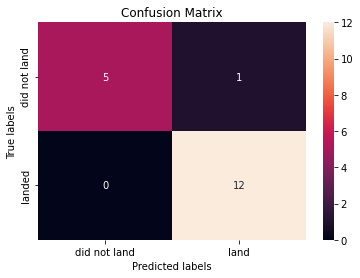

In [98]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

#### 4. KNN

In [99]:
parameters_knn = {'n_neighbors': list(range(1,51)),
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2,3]}

KNN = KNeighborsClassifier()

In [100]:
knn_cv = GridSearchCV(estimator=KNN, param_grid=parameters_knn, cv=10, scoring='precision')
knn_cv.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...],
                         'p': [1, 2, 3]},
             scoring='precision')

In [101]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 6, 'p': 1}
accuracy : 0.8266666666666665


In [102]:
knn_cv_score = knn_cv.score(X_test, Y_test)
knn_cv_score

0.8

#### KNN Confusion Matrix

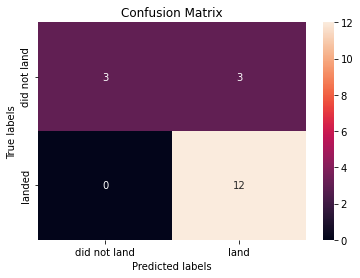

In [103]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

### Finding Best Performing Model

In [104]:
scores = {'logreg_cv_score': logreg_cv_score,
         'svm_cv_score' : svm_cv_score,
         'tree_cv_score': tree_cv_score,
         'knn_cv_score': knn_cv_score}
print(scores)
print('-------------------------')
print(f'{max(scores, key=scores.get)} is the best performing model with \
{scores[max(scores, key=scores.get)]} precision.')

{'logreg_cv_score': 0.9, 'svm_cv_score': 1.0, 'tree_cv_score': 0.9230769230769231, 'knn_cv_score': 0.8}
-------------------------
svm_cv_score is the best performing model with 1.0 precision.


#### Barchart of the Models and their precision

Text(0, 0.5, 'Success Rate')

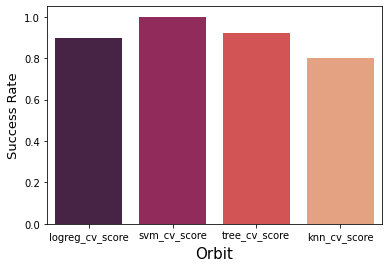

In [140]:
x = list(scores.keys())
y = list(scores.values())
sns.barplot(x=x, y=y, palette="rocket")
plt.xlabel('Orbit', fontsize=15,)
plt.ylabel('Success Rate', fontsize=13)